In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import statsmodels.api as sm
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#load data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
#select variables for model
categories2 = ['mszoning', 'street','centralair', 'kitchenqual']
#create dummy variables
house_df = pd.concat([house_df,pd.get_dummies(house_df.mszoning, prefix='mszoning', drop_first=True)], axis=1)
zoning_column_names = list(pd.get_dummies(house_df.mszoning, prefix='mszoning', drop_first=True).columns)
house_df['street_access'] = pd.get_dummies(house_df.street, drop_first=True)
house_df['has_AC'] = pd.get_dummies(house_df.centralair, drop_first=True)
house_df = pd.concat([house_df,pd.get_dummies(house_df.kitchenqual, prefix='kitchenqual', drop_first=True)], axis=1)
kitchen_column_names = list(pd.get_dummies(house_df.kitchenqual, prefix='kitchenqual', drop_first=True).columns)

In [4]:
#target variable
Y = house_df['saleprice']
#feature set
X = house_df[['overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 'garagearea', 
             'street_access', 'has_AC'] + zoning_column_names + kitchen_column_names]

#define linear model
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     371.8
Date:                Mon, 16 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:33:32   Log-Likelihood:                -17390.
No. Observations:                1460   AIC:                         3.481e+04
Df Residuals:                    1444   BIC:                         3.490e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.691e+04   1.89e+04     -1.426      0.154   -6.39e+04    1.01e+04
overallqual     1.777e+04   1163.014     15.280      0.000    1.55e+04    2.01e+04
totalbsmtsf       20.6404      4.047      5.100      0.000      12.702      28.579
firstflrsf         4.3663      4.793      0.911      0.362      -5.035      13.767
grlivarea         44.4075      2.521     17.617      0.000      39.463      49.352
garagecars      1.419e+04   2843.841      4.990      0.000    8613.025    1.98e+04
garagearea         7.2384      9.889      0.732      0.464     -12.161      26.638
street_access  -5206.4437   1.54e+04     -0.337      0.736   -3.55e+04    2.51e+04
has_AC          1.016e+04   4306.673      2.358      0.018    1708.935    1.86e+04
mszoning_FV     2.667e+04   1.31e+04      2.037      0.042     984.253    5.24e+04
mszoning_RH     1.783e+04    1.5e+04      1.187      0.235   -1.16e+04    4.73e+04
mszoning_RL     2.903e+04   1.22e+04      2.378      0.018    5085.883     5.3e+04
mszoning_RM      1.04e+04   1.23e+04      0.846      0.398   -1.37e+04    3.45e+04
kitchenqual_Fa -5.643e+04   7971.778     -7.079      0.000   -7.21e+04   -4.08e+04
kitchenqual_Gd     -5e+04   4259.903    -11.738      0.000   -5.84e+04   -4.16e+04
kitchenqual_TA -6.321e+04   4826.914    -13.096      0.000   -7.27e+04   -5.37e+04
==============================================================================
Omnibus:                      500.709   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56929.274
Skew:                          -0.544   Prob(JB):                         0.00
Kurtosis:                      33.572   Cond. No.                     6.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumption one: linearity of the model in its coefficients

This assumption is met by the way that we define the model.

## Assumption two: the error term should be zero on average

In [5]:
#calculate mean of error terms
predictions = results.predict(X)
errors = Y - predictions

print('Mean of the errors in the house prices model is: {}'.format(np.mean(errors)))

Mean of the errors in the house prices model is: -7.497625144785398e-09


The mean of the errors in the house prices model is very close to zero, so this assumption is met.

## Assumption three : homoscedasticity

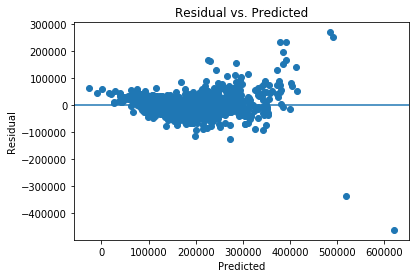

In [6]:
#plot residual vs predicted
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [7]:
#check for homoscedasticity
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print('Bartlett test statistic value is {0:3g} and p value is {1:.3g}'.format(bart_stats[0], bart_stats[1]))
print('Levene test statistic value is {0:3g} and p value is {1:.3g}'.format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 620.508 and p value is 5.8e-137
Levene test statistic value is 522.412 and p value is 1.67e-106


The p-values for both of these tests are very close to 0, so our errors are heteroscedastic, and this assumption is not met. To correct for this, we can try checking for outliers, adding different variables to the model, or performing a transformation of the sale price variable. If this does not work, we can still use the models, but statistical tests like the t-test may not be accurate.

## Assumption four: low multicollinearity

In [8]:
#get correlation between independent variables
X.corr()

,const,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea,street_access,has_AC,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA
const,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
overallqual,nan,1.000,0.538,0.476,0.593,0.601,0.562,0.059,0.272,0.172,-0.065,0.127,-0.196,-0.193,0.409,-0.554
totalbsmtsf,nan,0.538,1.000,0.820,0.455,0.435,0.487,0.005,0.208,-0.033,-0.055,0.257,-0.247,-0.125,0.173,-0.311
firstflrsf,nan,0.476,0.820,1.000,0.566,0.439,0.490,0.006,0.147,-0.095,-0.039,0.305,-0.267,-0.100,0.133,-0.274
grlivarea,nan,0.593,0.455,0.566,1.000,0.467,0.469,0.044,0.094,0.024,-0.001,0.133,-0.154,-0.082,0.226,-0.350
garagecars,nan,0.601,0.435,0.439,0.467,1.000,0.882,-0.020,0.234,0.103,-0.090,0.175,-0.222,-0.216,0.338,-0.399
garagearea,nan,0.562,0.487,0.490,0.469,0.882,1.000,-0.048,0.231,0.115,-0.073,0.170,-0.236,-0.200,0.292,-0.371
street_access,nan,0.059,0.005,0.006,0.044,-0.020,-0.048,1.000,0.070,0.014,0.007,0.045,-0.003,-0.056,0.053,-0.042
has_AC,nan,0.272,0.208,0.147,0.094,0.234,0.231,0.070,1.000,0.057,-0.132,0.203,-0.186,-0.301,0.188,-0.118
mszoning_FV,nan,0.172,-0.033,-0.095,0.024,0.103,0.115,0.014,0.057,1.000,-0.023,-0.417,-0.090,-0.036,0.209,-0.191


Some of our variables have a very high correlation with each other. To address this, we would want to remove some of the variables or use PCA to limit the number of features. For example, we might want to remove one of the variables describing garage area because the two variables are very highly correlated with each other.

## Assumption five: error terms should be uncorrelated with one another

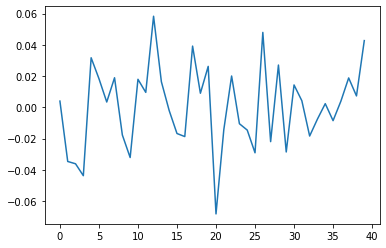

In [9]:
#plot autocorrelation of errors
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The correlation between errors ranges from about -0.06 to about 0.06, so the error terms are uncorrelated with each other and this assumption is met.

## Assumption six: features shouldn't be correlated with the errors

In [10]:
#check correlation between features and errors
print('Correlation between overall quality and errors: ', house_df['overallqual'].corr(errors))
print('Correlation between total basement square footage and errors: ', house_df['totalbsmtsf'].corr(errors))
print('Correlation between first floor square footage and errors: ', house_df['firstflrsf'].corr(errors))
print('Correlation between ground floor living area and errors: ', house_df['grlivarea'].corr(errors))
print('Correlation between garage capacity by number of cars and errors: ', house_df['garagecars'].corr(errors))
print('Correlation between garage area in square feet and errors: ', house_df['garagearea'].corr(errors))
print('Correlation between street access and errors: ', house_df['street_access'].corr(errors))
print('Correlation between A/C and errors: ', house_df['has_AC'].corr(errors))
print('Correlation between floating village residential zoning and errors: ', house_df['mszoning_FV'].corr(errors))
print('Correlation between residential high density zoning and errors: ', house_df['mszoning_RH'].corr(errors))
print('Correlation between residential low density zoning and errors: ', house_df['mszoning_RL'].corr(errors))
print('Correlation between residential medium density zoning and errors: ', house_df['mszoning_RM'].corr(errors))
print('Correlation between fair kitchen quality and errors: ', house_df['kitchenqual_Fa'].corr(errors))
print('Correlation between good kitchen quality and errors: ', house_df['kitchenqual_Gd'].corr(errors))
print('Correlation between average kitchen quality and errors: ', house_df['kitchenqual_TA'].corr(errors))

Correlation between overall quality and errors:  1.5948962706216175e-14
Correlation between total basement square footage and errors:  3.92599179948122e-14
Correlation between first floor square footage and errors:  4.2671821423213125e-14
Correlation between ground floor living area and errors:  4.257194783322821e-14
Correlation between garage capacity by number of cars and errors:  1.54163884512183e-14
Correlation between garage area in square feet and errors:  1.861354711877064e-14
Correlation between street access and errors:  7.979180290366199e-16
Correlation between A/C and errors:  3.3408250311727987e-15
Correlation between floating village residential zoning and errors:  -5.6764655485941155e-15
Correlation between residential high density zoning and errors:  -9.044086156086385e-18
Correlation between residential low density zoning and errors:  1.1400931142083718e-14
Correlation between residential medium density zoning and errors:  -9.597919064030411e-15
Correlation between fair

The correlation between each of the variables and the errors is very close to zero, so this assumption is meant.

## Normality of errors

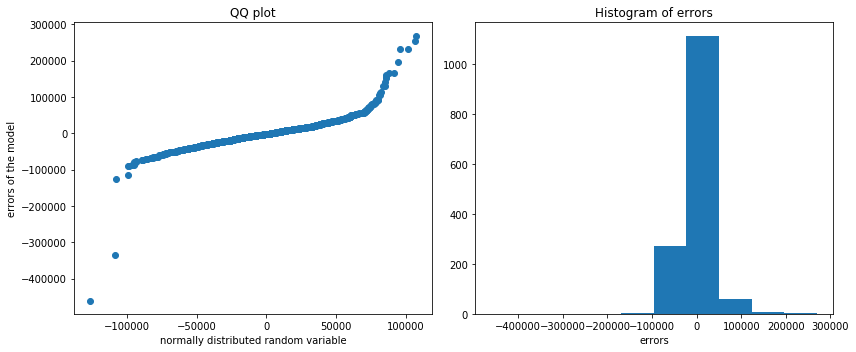

In [11]:
#define random normal variable
rand = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

#create QQ plot
plt.subplot(1,2,1)
plt.scatter(np.sort(rand), np.sort(errors))
plt.xlabel('normally distributed random variable')
plt.ylabel('errors of the model')
plt.title('QQ plot')

#plot histogram of errors
plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel('errors')
plt.title('Histogram of errors')

plt.tight_layout()
plt.show()

In [12]:
#test for normality
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print('Jarque-Bera test statistics is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
print('Normality test statistics is {0} and p value is {1}'.format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 56929.27425691875 and p value is 0.0
Normality test statistics is 500.708551181278 and p value is 1.8729215646166662e-109


The p-values of both of these tests indicate that our errors are not normally distributed. To address this, we could try adding in omitted variables or transforming the sale price variable.